#### sklearn/SVM tuning with MNIST

##### Libraries

In [1]:
using MLDatasets           # mnist
using Images
using PreprocessingImages; pim = PreprocessingImages
using PreprocessingArrays; pa  = PreprocessingArrays

using MLJ                  # make_blobs, rmse, confmat, categorical
using MLDataUtils          # label, nlabel, labelfreq
using PyCall               # required by ScikitLearn

using Metrics              # r2-score
using Random
using Plots; gr()
using StatsPlots
using DataFrames

##### Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    acc = accuracy(ŷ, y)
    f1  = multiclass_f1score(ŷ, y)
    println("accuracy: ", round(acc; digits=3))
    println("f1-score: ", round(f1;  digits=3))
    
    return (acc, f1)
end

printMetrics (generic function with 1 method)

##### Dataset

(28, 28, 60000)

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

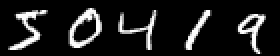

In [3]:
# load mnist
datasetX,    datasetY    = MNIST(:train)[:]
validationX, validationY = MNIST(:test)[:]

display( size(datasetX) )

img  = datasetX[:, :, 1:5]
img2 = permutedims(img, (2, 1, 3))

display(datasetY[1:5]')
mosaicview( Gray.(img2) ; nrow=1)

In [4]:
# split trainset, testset from dataset
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((datasetX, datasetY), p = 0.7)
size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

##### Preprocessing

In [5]:
function preprocess(X, y)
    newX = pim.batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X_tr, y_tr = preprocess(trainX, trainY);

##### Pipe the model

In [6]:
# reduce predictors
PCA = @load PCA pkg=MultivariateStats verbosity=0
reducer = PCA(pratio = 0.9)

# standardize predictors
std = Standardizer()

# svm scikitlearn
SVMClass = @load SVMClassifier pkg="ScikitLearn" verbosity=0
svm = SVMClass()

pipe = @pipeline reducer std svm

Pipeline280(
  pca = PCA(
        maxoutdim = 0, 
        method = :auto, 
        pratio = 0.9, 
        mean = nothing), 
  standardizer = Standardizer(
        features = Symbol[], 
        ignore = false, 
        ordered_factor = false, 
        count = false), 
  svm_classifier = SVMClassifier(
        C = 1.0, 
        kernel = "rbf", 
        degree = 3, 
        gamma = "auto", 
        coef0 = 0.0, 
        shrinking = true, 
        tol = 0.001, 
        cache_size = 200, 
        max_iter = -1, 
        decision_function_shape = "ovr", 
        random_state = nothing))

##### Training

In [7]:
mach = MLJ.machine(pipe, X_tr, y_tr) |> fit!

┌ Info: Training machine(Pipeline280(pca = PCA(maxoutdim = 0, …), …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(PCA(maxoutdim = 0, …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


┌ Info: Training machine(SVMClassifier(C = 1.0, …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487


Machine trained 1 time; caches data
  model: Pipeline280(pca = PCA(maxoutdim = 0, …), …)
  args: 
    1:	Source @081 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @398 ⏎ `AbstractVector{OrderedFactor{10}}`


##### Testing

In [10]:
X_ts, y_ts = preprocess(testX, testY)
ŷ = MLJ.predict(mach, X_ts)
accTest, f1Test = printMetrics(ŷ, y_ts);

10×10 Matrix{Int64}:
 1754     0     2     0     1     3     7     1     1     2
    2  1997     2     0     2     3     0     4     8     1
    5     7  1754    20     2     1     1    14     5     2
    2     2     2  1779     0    18     0     0    10    11
    1     3     6     0  1729     4     3    13     2     5
    4     1     1     9     0  1581     9     1    10     3
    7     0     2     0     4     8  1751     0     5     0
    0     5    11     8     3     0     0  1826     3    13
    1     6     5    18     3     6     4     2  1705    12
    1     2     2     5     9     2     0    18     6  1736

accuracy: 0.978
f1-score: 0.978


##### Evaluate

The machine model obtained is now evaluated for accuracy and f1 through cross-validdation with the trainset.

##### Single parameter

In [11]:
measures("accuracy")[1]

`Accuracy` - accuracy type with instances `accuracy`. 
(name = "Accuracy",
 instances = ["accuracy"],
 human_name = "accuracy",
 target_scitype = Union{AbstractArray{var"#s1289", N} where {var"#s1289"<:Union{Missing, Multiclass{N}}, N}, AbstractArray{var"#s1288", N} where {var"#s1288"<:Union{Missing, OrderedFactor{N}}, N}} where N,
 supports_weights = true,
 supports_class_weights = false,
 prediction_type = :deterministic,
 orientation = :score,
 reports_each_observation = false,
 aggregation = StatisticalTraits.Mean(),
 is_feature_dependent = false,
 docstring = "`Accuracy` - accuracy type with instances `accuracy`. ",
 distribution_type = Unknown,)

In [12]:
cv = CV(nfolds=3)

CV(
  nfolds = 3, 
  shuffle = false, 
  rng = Random._GLOBAL_RNG())

In [14]:
evr = MLJ.evaluate(pipe, X_tr, y_tr,              # trainset
                   resampling=cv,
                   measure=accuracy,
                   acceleration=CPUProcesses(),   # CPUThreads()
                   verbosity=0)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────┬───────────┬─────────────┬─────────┬───────────────────────┐
│ measure    │ operation │ measurement │ 1.96*SE │ per_fold              │
├────────────┼───────────┼─────────────┼─────────┼───────────────────────┤
│ Accuracy() │ predict   │ 0.975       │ 0.00255 │ [0.973, 0.976, 0.976] │
└────────────┴───────────┴─────────────┴─────────┴───────────────────────┘


In [19]:
evr.measure

1-element Vector{Accuracy}:
 Accuracy()

In [16]:
evr.per_fold

1-element Vector{Vector{Float64}}:
 [0.9729305049639312, 0.9762142857142857, 0.976]

##### Multiple parameters

In [18]:
meas = [accuracy, multiclass_f1score]
cv   = CV(nfolds=10)
evaluationResult = MLJ.evaluate(pipe, X_tr, y_tr,   # trainset
                   resampling=cv,
                   measure=meas,
                   acceleration=CPUProcesses(),     # CPUThreads()
                   verbosity=0)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────────────────────────────┬───────────┬─────────────┬────
│ measure                                        │ operation │ measurement │ 1 ⋯
├────────────────────────────────────────────────┼───────────┼─────────────┼────
│ Accuracy()                                     │ predict   │ 0.977       │ 0 ⋯
│ MulticlassFScore(                              │ predict   │ 0.977       │ 0 ⋯
│   β = 1.0,                                     │           │             │   ⋯
│   average = MLJBase.MacroAvg(),                │           │             │   ⋯
│   return_type = OrderedCollections.LittleDict) │           │             │   ⋯
└────────────────────────────────────────────────┴───────────┴─────────────┴────
                                                               2 columns omitted


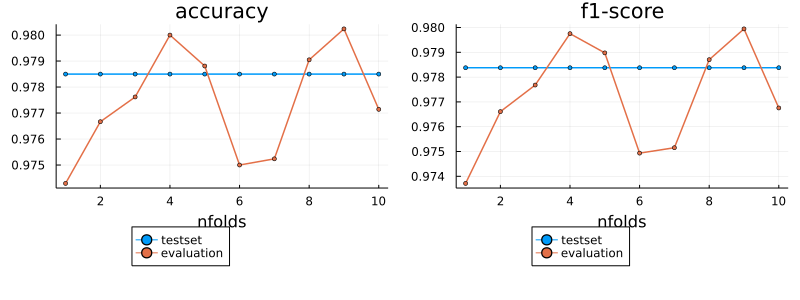

In [20]:
xs = 1:10

# accuracy
ys = repeat([accTest], 10)
ys = hcat(ys, evaluationResult.per_fold[1])
p1 = plot(xs, ys, title="accuracy")

# f1
ys = repeat([f1Test], 10)
ys = hcat(ys, evaluationResult.per_fold[2])
p2 = plot(xs, ys, title="f1-score")
     
# plots
plot(p1, p2, layout = (1, 2), size=(800,300),
     label=["testset" "evaluation"],
     xlabel="nfolds",
     linewidth=1.5,
     markershape=:circle,
     markersize=3,
     legend=:outerbottom)

##### Tuning

In [21]:
r = range(pipe, :(svm_classifier.C), lower=1e-3, upper=1.0, scale=:log)

NumericRange(0.001 ≤ svm_classifier.C ≤ 1.0; origin=0.5005, unit=0.4995) on log scale

In [22]:
cv   = CV(nfolds=10)
selfTuningPipe = TunedModel(model=pipe,
                            resampling=cv,
                            tuning=Grid(resolution=3),
                            range=r,
                            measure=accuracy,
                            acceleration=CPUProcesses())

DeterministicTunedModel(
  model = Pipeline280(
        pca = PCA(maxoutdim = 0, …), 
        standardizer = Standardizer(features = Symbol[], …), 
        svm_classifier = SVMClassifier(C = 1.0, …)), 
  tuning = Grid(
        goal = nothing, 
        resolution = 3, 
        shuffle = true, 
        rng = Random._GLOBAL_RNG()), 
  resampling = CV(
        nfolds = 10, 
        shuffle = false, 
        rng = Random._GLOBAL_RNG()), 
  measure = Accuracy(), 
  weights = nothing, 
  operation = nothing, 
  range = NumericRange(0.001 ≤ svm_classifier.C ≤ 1.0; origin=0.5005, unit=0.4995) on log scale, 
  selection_heuristic = MLJTuning.NaiveSelection(nothing), 
  train_best = true, 
  repeats = 1, 
  n = nothing, 
  acceleration = CPUProcesses{Nothing}(nothing), 
  acceleration_resampling = CPU1{Nothing}(nothing), 
  check_measure = true, 
  cache = true)

In [23]:
iterator(r, 5)

5-element Vector{Float64}:
 0.0010000000000000002
 0.005623413251903492
 0.0316227766016838
 0.1778279410038923
 1.0

In [25]:
mach = machine(selfTuningPipe, X_tr, y_tr) |> fit!

┌ Info: Training machine(DeterministicTunedModel(model = Pipeline280(pca = PCA(maxoutdim = 0, …), …), …), …).
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/QZctr/src/machines.jl:487
┌ Info: Attempting to evaluate 3 models.
└ @ MLJTuning /home/ciro/.julia/packages/MLJTuning/5ukRd/src/tuned_models.jl:683


Evaluating over 3 metamodels:   0%[>                        ]  ETA: N/A

Evaluating over 3 metamodels:  33%[========>                ]  ETA: 1:41:46

Evaluating over 3 metamodels:  67%[================>        ]  ETA: 0:36:22

Evaluating over 3 metamodels: 100%[=========================] Time: 1:20:21


Machine trained 1 time; caches data
  model: DeterministicTunedModel(model = Pipeline280(pca = PCA(maxoutdim = 0, …), …), …)
  args: 
    1:	Source @405 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @084 ⏎ `AbstractVector{OrderedFactor{10}}`


In [27]:
# best parameter for the search
println("Best C: ", fitted_params(mach).best_model.svm_classifier.C)

Best C: 1.0


In [26]:
MLJ.save("svm-tuning-model.jlso", mach)